# Create model from 3D Phantom snapshot

In [2]:
import os
import sys
import numpy             as np
import matplotlib.pyplot as plt
import meshio            as mio
import magritte.tools    as tools
import magritte.setup    as setup
import magritte.mesher   as mesher
import magritte.core     as magritte

from ipywidgets           import Dropdown, interact
from scipy.spatial        import Delaunay
from scipy.interpolate    import griddata
from astropy              import units, constants
from tqdm                 import tqdm
from palettable.cubehelix import cubehelix2_16
from matplotlib.gridspec  import GridSpec
from matplotlib           import rcParams, rc
from glob                 import glob

# Change the matplotlib default parameters
rcParams.update({'font.size':   14})
rcParams.update({'figure.dpi': 250})
rc('font', family='serif')
rc('text', usetex=True)

In [3]:
menu = Dropdown(
           options = [
               '/home/frederik/IvS/Silke/slides/wind_v05a4e00m100.ascii',
               '/home/frederik/IvS/Silke/slides/wind_v20a9e00m100.ascii',
               '/home/frederik/IvS/Jolien/slides/v10a6e00m100.ascii',
               '/home/frederik/IvS/Jolien/slides/v10a6e50m100.ascii'
           ],
           description = 'Phantom file: '
       )
menu

Dropdown(description='Phantom file: ', options=('/home/frederik/IvS/Silke/slides/wind_v05a4e00m100.ascii', '/h…

In [4]:
name      = os.path.splitext(menu.value)[0]
modelFile = name + '.hdf5'
modelFile

'/home/frederik/IvS/Jolien/slides/v10a6e50m100.hdf5'

In [5]:
qqq = 1

In [6]:
(x,y,z, h, rho, vx,vy,vz, u) = np.loadtxt(menu.value, skiprows=14, usecols=(0,1,2,4,5,6,7,8,9), unpack=True)

In [7]:
dimension = 3
nrays     = 2
nspecs    = 5
nlspecs   = 1
nquads    = 75

gamma = 1.2
mu    = 2.381

velocity_cte = 2.9784608e+06 * 1.0e-2
density_cte  = 5.9410314e-07
energy_cte   = 8.8712277e+12

# density_min  = 1.0e-6 / (density_cte * 1.0e+6 * constants.N_A.si.value / 2.02)

lamdaFile = '../data/co.txt'

nH2 = 1.6e-10
nCO = 7.8e-12

x   = x  [h>0.0]
y   = y  [h>0.0]
z   = z  [h>0.0]
rho = rho[h>0.0]
vx  = vx [h>0.0]
vy  = vy [h>0.0]
vz  = vz [h>0.0]
u   = u  [h>0.0]

# rho[rho<density_min] = density_min

npoints = len(x)

zeros = np.zeros(npoints)
ones  = np.ones (npoints)

position = np.array((x, y, z )).transpose()
velocity = np.array((vx,vy,vz)).transpose()

position = position * constants.au.si.value
velocity = velocity * (velocity_cte / constants.c.cgs.value)

In [8]:
delaunay = Delaunay(position)

In [9]:
# Extract Delaunay vertices (= Voronoi neighbors)
(indptr, indices) = delaunay.vertex_neighbor_vertices
neighbors = [indices[indptr[k]:indptr[k+1]] for k in range(npoints)]
nbs       = [n for sublist in neighbors for n in sublist]
n_nbs     = [len(sublist) for sublist in neighbors]

# Compute the indices of the boundary particles
boundary = set([])
for i in tqdm(range(delaunay.neighbors.shape[0])):
    m1  = (delaunay.neighbors[i] == -1)
    nm1 = np.sum(m1)
    if   (nm1 == 0):
        pass
    elif (nm1 == 1):
        for b in delaunay.simplices[i][m1]:
            boundary.add(b)
    elif (nm1 >= 2):
        for b in delaunay.simplices[i]:
            boundary.add(b)
boundary = list(boundary)

bdy = np.array(boundary)

b_nms = np.linalg.norm(position[bdy], axis=1)
p_nms = np.linalg.norm(position,      axis=1)

boundary = np.array([i[0] for i in np.argwhere(p_nms >= np.min(b_nms))])

nH2 = rho * density_cte * 1.0e+6 * constants.N_A.si.value / 2.02
nCO = nH2 * 1.0e-4

tmp = mu * (gamma-1.0) * u * energy_cte * 1.00784 * (units.erg/units.g * constants.u/constants.k_B).to(units.K).value
tmp[tmp<2.725 ] = 2.725
# tmp[tmp>5.0e+4] = 5.0e+4

trb = (150.0/constants.c.si.value)**2 * ones

100%|██████████| 7652884/7652884 [00:48<00:00, 156992.93it/s]


In [10]:
model = magritte.Model ()
model.parameters.set_spherical_symmetry(False)
model.parameters.set_pop_prec          (1.0e-6)
model.parameters.set_model_name        (modelFile)
model.parameters.set_dimension         (dimension)
model.parameters.set_npoints           (npoints)
model.parameters.set_nrays             (nrays)
model.parameters.set_nspecs            (nspecs)
model.parameters.set_nlspecs           (nlspecs)
model.parameters.set_nquads            (nquads)

model.geometry.points.position.set(position)
model.geometry.points.velocity.set(velocity)

model.geometry.points.  neighbors.set(  nbs)
model.geometry.points.n_neighbors.set(n_nbs)

model.chemistry.species.abundance = np.array((zeros, nCO, nH2, zeros, ones)).T
model.chemistry.species.symbol    = ['dummy0', 'CO', 'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set(tmp)
model.thermodynamics.turbulence.vturb2.set(trb)

model.parameters.set_nboundary(boundary.shape[0])
model.geometry.boundary.boundary2point.set(boundary)


incl = 40
sini = np.sin(incl/180*np.pi)
cosi = np.cos(incl/180*np.pi)
direction = np.array([[0,sini,cosi], [0,-sini,-cosi]])
# direction = np.array([[+1,0,0], [-1,0,0]])

model.geometry.rays.direction.set(direction)
model.geometry.rays.weight   .set((1.0/nrays) * np.ones(nrays))

model = setup.set_boundary_condition_CMB  (model)
model = setup.set_linedata_from_LAMDA_file(model, lamdaFile, {'considered transitions': [0]})
model = setup.set_quadrature              (model)

model.write()

Not considering all radiative transitions on the data file but only the specified ones!


In [11]:
model.parameters.npoints()

1138671

In [12]:
model = magritte.Model (modelFile)

model.compute_spectral_discretisation ()
model.compute_inverse_line_widths     ()
model.compute_LTE_level_populations   ()

0

In [7]:
np.min(model.geometry.points.velocity) * magritte.CC

-875.7394348129279

In [7]:
np.max(model.geometry.points.velocity) * magritte.CC

882.1669277438724

In [8]:
np.max(tmp)

NameError: name 'tmp' is not defined

In [ ]:
np.min(tmp)

In [13]:
fcen = model.lines.lineProducingSpecies[0].linedata.frequency[0]
vpix = 125
dd = vpix * (model.parameters.nfreqs()-1)/2 / magritte.CC
fmin = fcen - fcen*dd
fmax = fcen + fcen*dd

model.compute_spectral_discretisation (fmin, fmax)
model.compute_image (model.parameters.hnrays()-1)

imx = np.array(model.images[-1].ImX)
imy = np.array(model.images[-1].ImY)
imI = np.array(model.images[-1].I)
imv = np.array(model.radiation.frequencies.nu)[0]

In [13]:
np.count_nonzero(np.isnan(imI)) // model.parameters.nfreqs()

0

In [14]:
# Extract the number of frequency bins
nfreqs = model.parameters.nfreqs()

# Set number of pixels in x and y direction
ngridx = 300
ngridy = 300

# Set a zoom factor
zoom = 1.3

# Set image boundaries
x_min, x_max = np.min(imx)/zoom, np.max(imx)/zoom
y_min, y_max = np.min(imy)/zoom, np.max(imy)/zoom

# Create image grid values
xs = np.linspace(x_min, x_max, ngridx)
ys = np.linspace(y_min, y_max, ngridy)

# Extract the spectral / velocity data
freqs = np.array(model.radiation.frequencies.nu)[0]
f_ij  = np.mean(freqs)
velos = (freqs - f_ij) / f_ij * constants.c.si.value * 1.0e-3   # [km/s]

# Interpolate the scattered data to an image (regular grid)
Is = np.zeros((nfreqs))
zs = np.zeros((nfreqs, ngridx, ngridy))
for f in range(nfreqs):
    zs[f] = griddata((imx, imy), imI[:,f], (xs[None,:], ys[:,None]), method='nearest')
    Is[f] = np.sum(zs[f])
Is = Is / np.max(Is)

# Get the logarithm of the data (matplotlib has a hard time handling logarithmic data.)
log_zs     = np.log(zs)
log_zs_min = np.min(log_zs)
log_zs_max = np.max(log_zs)

In [15]:
au = (1.0 * units.au).si.value

In [16]:
%%capture

# figs = []
gs   = GridSpec(1,2, wspace=.1, width_ratios=[2, 1])

for f in range(nfreqs):
    
    fig = plt.figure(dpi=300)
    ax1 = fig.add_subplot(gs[0])
    ax1.set_title('View at 40 deg. inc.', fontsize=14)
#     ax1.contourf(xs/au, ys/au, log_zs[f], cmap=cubehelix2_16.mpl_colormap, vmin=log_zs_min, vmax=log_zs_max, levels=250)
    ax1.contourf(xs/au, ys/au, log_zs[f], cmap=cubehelix2_16.mpl_colormap, levels=250)
    ax1.set_aspect('equal')
    ax1.set_xlabel('image x [au]', labelpad = 10)
    ax1.set_ylabel('image y [au]', labelpad = 10)
    
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(velos, Is/np.max(Is))
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.axvline(velos[f], c='red')
    ax2.set_ylabel('Relative intensity', labelpad=15)
    ax2.set_xlabel('velocity [km/s]',    labelpad=10)
    asp = 2*np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
    ax2.set_aspect(asp)
    
    plt.savefig(f"{name}_image_{f:0>3d}_incl_{incl}.png", bbox_inches='tight')
    
#     figs.append(fig)

In [31]:
interact(lambda q: figs[q], q=(0, len(figs)-1))

NameError: name 'figs' is not defined

In [20]:
import imageio
from glob import glob

In [21]:
files = sorted(glob(f'{name}_image*_incl_{incl}.png'))
files

['/home/frederik/IvS/Jolien/slides/v10a6e50m100_image_000_incl_40.png',
 '/home/frederik/IvS/Jolien/slides/v10a6e50m100_image_001_incl_40.png',
 '/home/frederik/IvS/Jolien/slides/v10a6e50m100_image_002_incl_40.png',
 '/home/frederik/IvS/Jolien/slides/v10a6e50m100_image_003_incl_40.png',
 '/home/frederik/IvS/Jolien/slides/v10a6e50m100_image_004_incl_40.png',
 '/home/frederik/IvS/Jolien/slides/v10a6e50m100_image_005_incl_40.png',
 '/home/frederik/IvS/Jolien/slides/v10a6e50m100_image_006_incl_40.png',
 '/home/frederik/IvS/Jolien/slides/v10a6e50m100_image_007_incl_40.png',
 '/home/frederik/IvS/Jolien/slides/v10a6e50m100_image_008_incl_40.png',
 '/home/frederik/IvS/Jolien/slides/v10a6e50m100_image_009_incl_40.png',
 '/home/frederik/IvS/Jolien/slides/v10a6e50m100_image_010_incl_40.png',
 '/home/frederik/IvS/Jolien/slides/v10a6e50m100_image_011_incl_40.png',
 '/home/frederik/IvS/Jolien/slides/v10a6e50m100_image_012_incl_40.png',
 '/home/frederik/IvS/Jolien/slides/v10a6e50m100_image_013_incl_4

In [22]:
images = []
for file in files:
    images.append(imageio.imread(file))
imageio.mimsave(f'{name}_movie_incl_{incl}.gif', images)

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,
         0.,  1.,  0.,  2.,  0.,  1.,  1.,  0.,  3.,  0.,  2.,  2.,  2.,
         5.,  4.,  5.,  2.,  1.,  5.,  5.,  5., 11.,  3., 10., 10., 11.,
        12., 13., 15., 18., 19., 23., 25., 23., 24., 33., 24., 41., 46.,
        41., 58., 65., 71., 53., 47., 58., 81., 75., 68., 71., 86., 77.,
        61., 78., 74., 64., 69., 64., 73., 68., 69., 47., 49., 49., 50.,
        29., 40., 30., 21., 24., 18., 16.,  9.,  9.]),
 array([2.11309620e+13, 2.11461620e+13, 2.11613620e+13, 2.11765620e+13,
        2.11917620e+13, 2.12069621e+13, 2.12221621e+13, 2.12373621e+13,
        2.12525621e+13, 2.12677621e+13, 2.12829621e+13, 2.12981622e+13,
        2.13133622e+13, 2.13285622e+13, 2.13437622e+13, 2.13589622e+13,
        2.13741622e+13, 2.13893623e+13, 2.14045623e+13, 2.14197623e+13,
        2.14349623e+13, 2.14501623e+13, 2.14653624e+13, 2.14805624e+13,
  

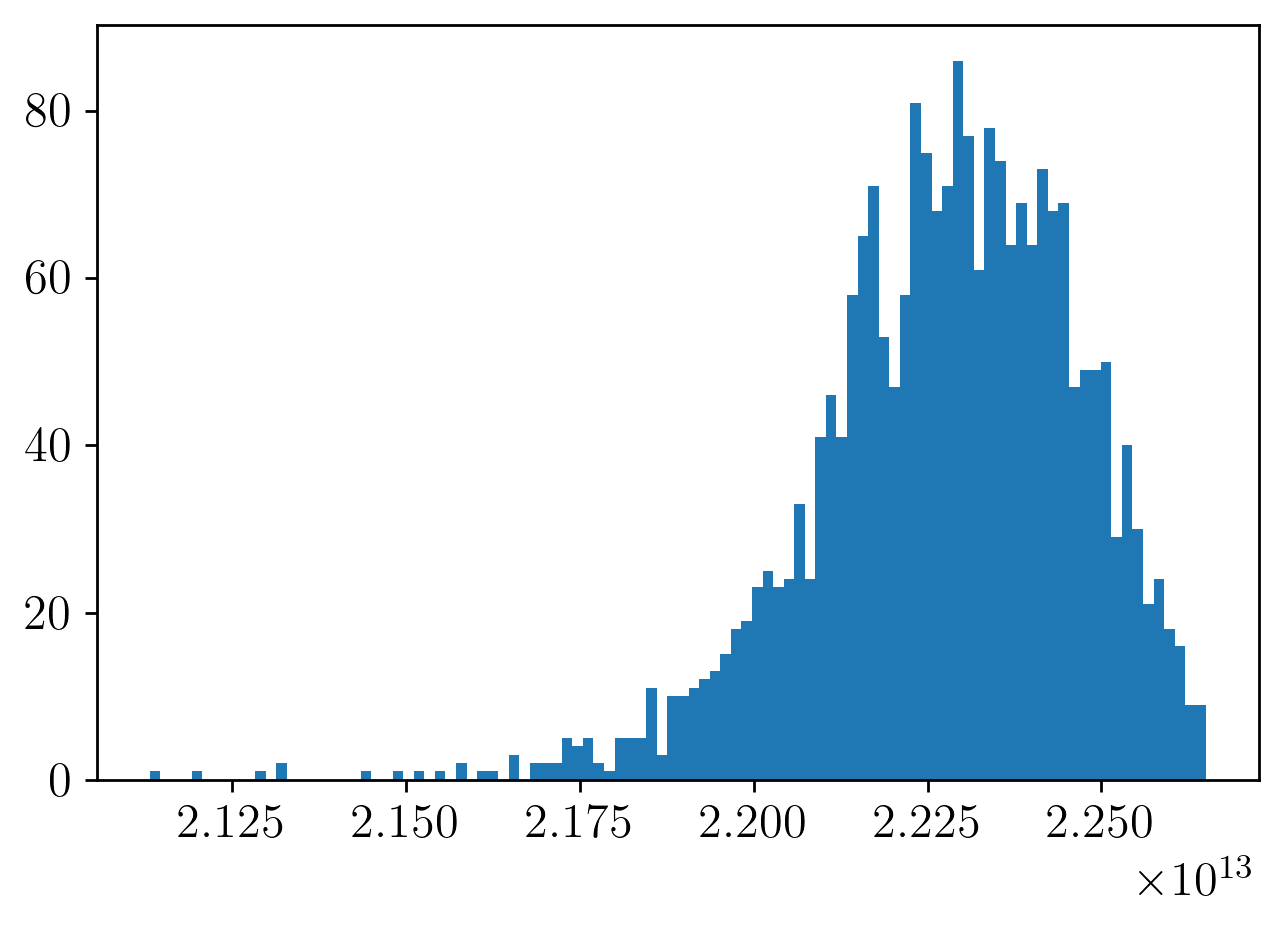

In [50]:
plt.hist(xbs, bins=100)

In [21]:
np.array(model.geometry.rays.direction)[model.parameters.hnrays()-1]

array([6.123234e-17, 1.000000e+00, 0.000000e+00])

In [22]:
np.array(model.geometry.rays.direction)

array([[ 5.27046277e-01,  5.27046277e-01,  6.66666667e-01],
       [-5.27046277e-01,  5.27046277e-01,  6.66666667e-01],
       [-5.27046277e-01, -5.27046277e-01,  6.66666667e-01],
       [ 5.27046277e-01, -5.27046277e-01,  6.66666667e-01],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.12323400e-17,  1.00000000e+00,  0.00000000e+00],
       [-1.00000000e+00,  1.22464680e-16,  0.00000000e+00],
       [-1.83697020e-16, -1.00000000e+00,  0.00000000e+00],
       [ 5.27046277e-01,  5.27046277e-01, -6.66666667e-01],
       [-5.27046277e-01,  5.27046277e-01, -6.66666667e-01],
       [-5.27046277e-01, -5.27046277e-01, -6.66666667e-01],
       [ 5.27046277e-01, -5.27046277e-01, -6.66666667e-01]])

NameError: name 'xs' is not defined

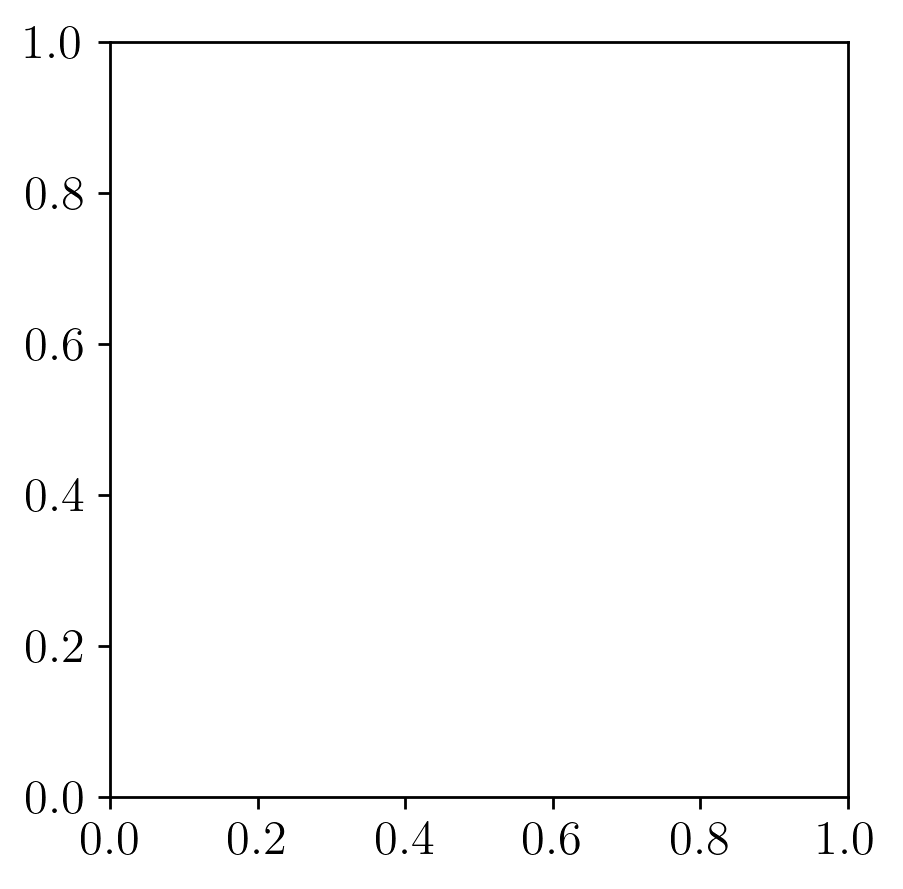

In [18]:
f = 10


gs  = GridSpec(1,2, wspace=.1, width_ratios=[2, 1])
fig = plt.figure(dpi=250)
    
ax1 = fig.add_subplot(gs[0])
# ax1.contourf(xs, ys, log_zs[f], cmap=cubehelix2_16.mpl_colormap, vmin=log_zs_min, vmax=log_zs_max, levels=50)
ax1.contourf(xs, ys, log_zs[f], cmap='gist_rainbow', levels=50)
ax1.set_aspect('equal')
ax1.set_xlabel('image x [m]', labelpad = 10)
ax1.set_ylabel('image y [m]', labelpad = 10)
    
ax2 = fig.add_subplot(gs[1])
ax2.plot(velos, Is/np.max(Is))
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.axvline(velos[f], c='red')
ax2.set_ylabel('Relative intensity', labelpad=15)
ax2.set_xlabel('velocity [km/s]',    labelpad=10)
asp = 2*np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
ax2.set_aspect(asp)

In [7]:
import yt

/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [8]:
ds = yt.load_unstructured_mesh(
             connectivity = np.array(delaunay.simplices, dtype=np.int64),
             coordinates  = np.array(delaunay.points,    dtype=np.float64),
             node_data    = {('connect1', 'rho'): np.array(rho[delaunay.simplices], dtype=np.float64)})

yt : [INFO     ] 2021-02-09 09:25:23,042 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-02-09 09:25:23,042 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-02-09 09:25:23,043 Parameters: domain_left_edge          = [-2.48715126e+13 -2.45523465e+13 -2.46134368e+13]
yt : [INFO     ] 2021-02-09 09:25:23,044 Parameters: domain_right_edge         = [2.43170504e+13 2.46598931e+13 2.46277797e+13]
yt : [INFO     ] 2021-02-09 09:25:23,045 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2021-02-09 09:27:09,033 xlim = -24871512624339.960938 24317050406673.148438
yt : [INFO     ] 2021-02-09 09:27:09,034 ylim = -24552346464788.742188 24659893122024.320312
yt : [INFO     ] 2021-02-09 09:27:09,036 xlim = -24871512624339.960938 24317050406673.148438
yt : [INFO     ] 2021-02-09 09:27:09,036 ylim = -24552346464788.742188 24659893122024.320312
yt : [INFO     ] 2021-02-09 09:27:09,038 Making a fixed resolution buffer of (('all', 'rho')) 800 by 800
yt : [INFO     ] 2021-02-09 09:27:10,384 Making a fixed resolution buffer of (('all', 'rho')) 800 by 800
/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setti


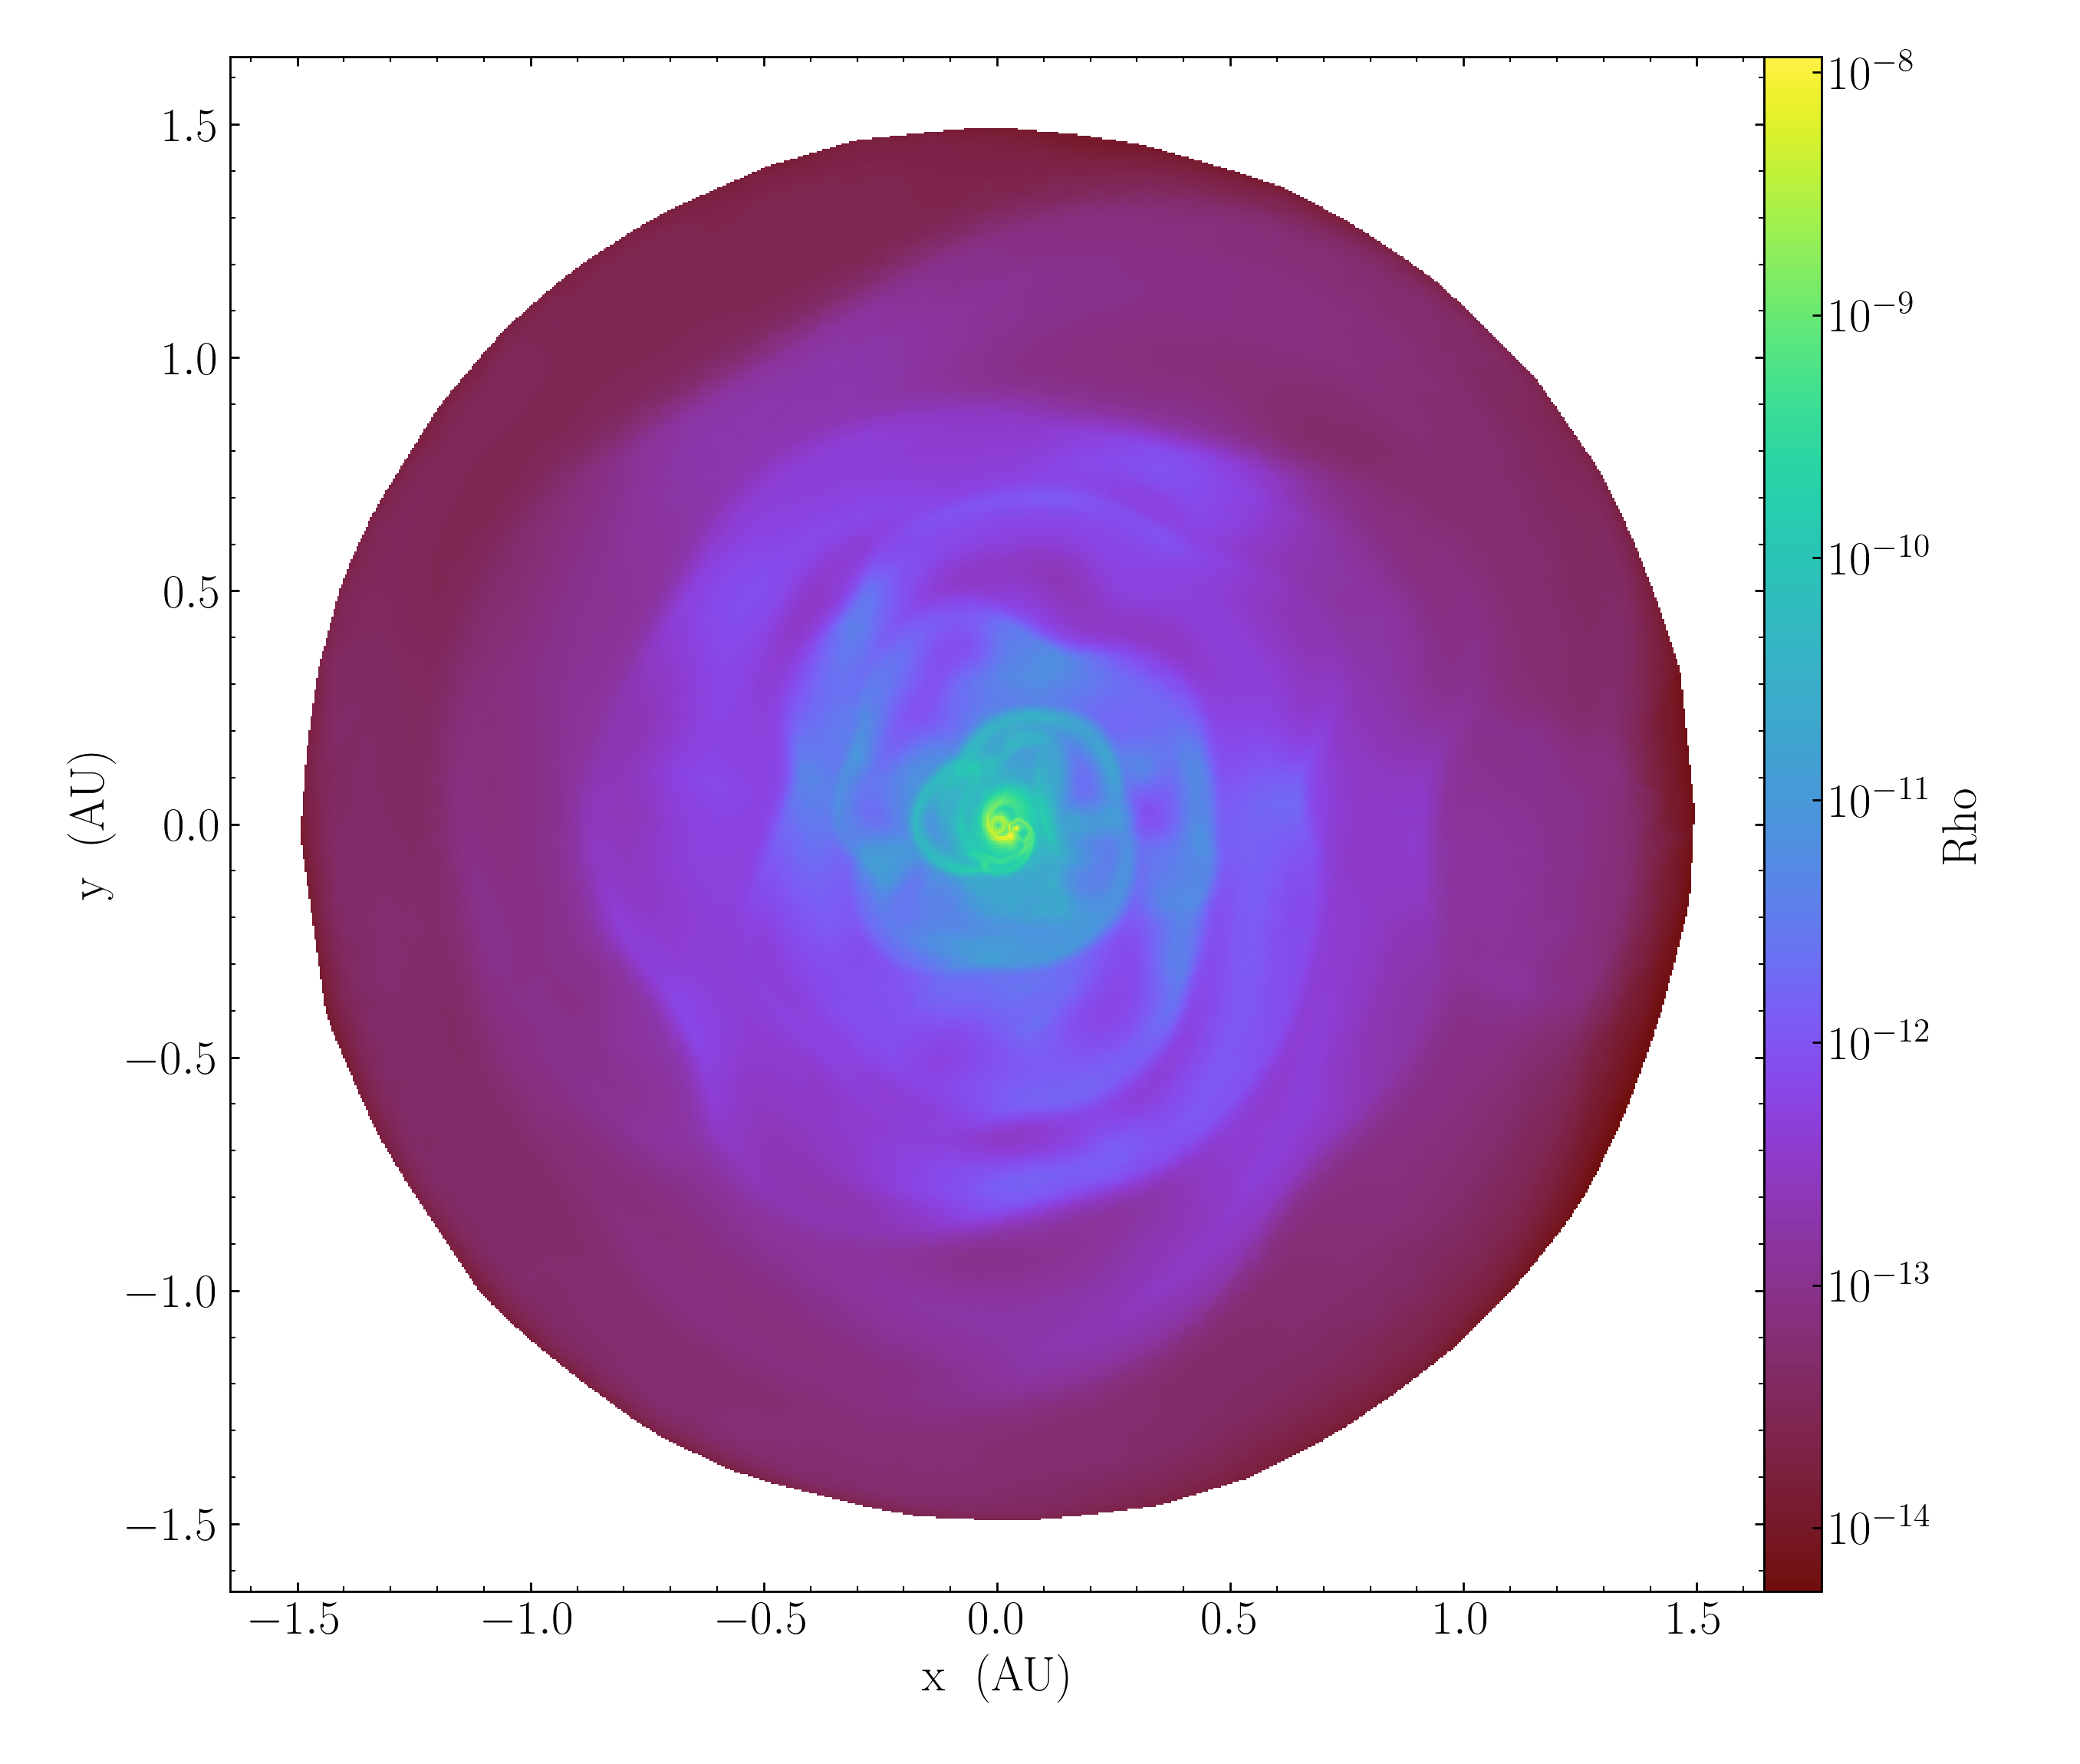

In [13]:
sl = yt.SlicePlot(ds, 'z', 'rho')
sl.zoom(1)

In [ ]:
    sl.set_log             (quantity, True)
    sl.set_background_color(quantity)
    sl.set_cmap            (quantity, 'magma')
    sl.set_zlim            (quantity, 1e-18, 5e-12)
    sl.set_axes_unit       ('au')
    sl.zoom                (zoom)

In [34]:
rho

array([2.40741320e-09, 2.40525360e-09, 2.37015140e-09, ...,
       3.55204130e-09, 5.64597069e-24, 5.64597069e-24])

In [42]:
np.int64_t

AttributeError: module 'numpy' has no attribute 'int64_t'

In [45]:
rho[delaunay.simplices]

array([[1.2356285e-14, 1.7251232e-14, 1.7188296e-14, 1.5339248e-14],
       [1.2356285e-14, 1.7251232e-14, 1.5348230e-14, 1.7188296e-14],
       [1.1785666e-14, 1.4296989e-14, 8.7650478e-15, 8.7189980e-15],
       ...,
       [3.7175572e-09, 3.6443935e-09, 4.5509183e-09, 4.4362007e-09],
       [3.7175572e-09, 4.8835229e-09, 5.5573719e-09, 5.4662070e-09],
       [3.7175572e-09, 4.5509183e-09, 5.5573719e-09, 5.4662070e-09]])